# Data Preparation

In [1]:
# There are 2 datasets , one with 20k data and other with 200k data
# Our goal is to train on the 20k dataset and later scale it up for the other dataset (dev.text is the validation set)

In [2]:
# We're using the 20k numbers replaced dataset, lets set its path
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [3]:
# Check all the filenames in the directory
import os
filenames = [data_dir+filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [4]:
# Visualize examples from the data
def get_lines(filename):
    """
    Reads filename and returns the lines of text as a list"""
    file = open(data_dir+filename,"r")
    lines = []
    # Read the lines
    for line in file:
        lines.append(line.strip())

    return lines 

In [5]:
# Save the training data as a list
train_lines = get_lines("train.txt")

In [6]:
# Check the first index in the list of sentences
train_lines[0]

'###24293578'

In [7]:
df = {} # Make a dictionary

for line in train_lines:
    if not line:
        continue
    if line[0] != "#":
        parts = line.split("\t")
        label = parts[0]
        sentence = parts[1]
        df[sentence] = label
    else:
        pass

df

{'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .': 'OBJECTIVE',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .': 'METHODS',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .': 'METHODS',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .': 'METHODS',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .': 'METHODS',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive

In [8]:
# turn it into a pd DataFrame
import pandas as pd
train_df = pd.DataFrame(list(df.items()), columns = [["sentence","label"]])
train_df

,sentence,label
0,To investigate the efficacy of @ weeks of dail...,OBJECTIVE
1,A total of @ patients with primary knee OA wer...,METHODS
2,Outcome measures included pain reduction and i...,METHODS
3,Pain was assessed using the visual analog pain...,METHODS
4,Secondary outcome measures included the Wester...,METHODS
...,...,...
176941,For the absolute change in percent atheroma vo...,RESULTS
176942,"For PAV , a significantly greater percentage o...",RESULTS
176943,Both strategies had acceptable side effect pro...,RESULTS
176944,"Compared with standard statin monotherapy , th...",CONCLUSIONS


In [9]:
#Let's also import the validation data and process it
valid_lines = get_lines("dev.txt") # Save the data as a list

valid_df = {} # Make a dictionary to store the list as 2 items in a row

for line in valid_lines:
    if not line:
        continue
    if line[0] != "#":
        parts = line.split("\t")
        label = parts[0]
        sentence = parts[1]
        valid_df[sentence] = label
    else:
        pass

valid_df = pd.DataFrame(list(valid_df.items()), columns = [["sentence","label"]])
valid_df

,sentence,label
0,IgE sensitization to Aspergillus fumigatus and...,BACKGROUND
1,It is not clear whether these patients would b...,BACKGROUND
2,We sought to determine whether a @-month cours...,OBJECTIVE
3,Asthmatic patients who were IgE sensitized to ...,METHODS
4,Primary outcomes were improvement in quality o...,METHODS
...,...,...
29885,Pruritus occurred more frequently with the act...,RESULTS
29886,Three patients in the active-regimen group ( @...,RESULTS
29887,Hemoglobin values of grade @ ( @ to < @ g per ...,RESULTS
29888,Rates of response to a @-week interferon-free ...,CONCLUSIONS


In [10]:
train_sentences = train_df["sentence"]
train_sentences.iloc[0]

sentence    To investigate the efficacy of @ weeks of dail...
Name: 0, dtype: object

In [63]:
train_df["label"].value_counts()

(label,)   
METHODS        58416
RESULTS        57702
CONCLUSIONS    26897
BACKGROUND     20107
OBJECTIVE      13824
Name: count, dtype: int64

In [11]:
# Finding the maximum number of words in a sentence for the whole datatset 
i = 0
words = 15
for i in range(0, len(train_sentences)):
    
    if len(str(train_sentences.iloc[i]).split()) > words:
        index = i
        words = len(str(train_sentences.iloc[i]).split())
    else:
        pass

index, words
    

(100044, 28)

In [12]:
# split our sentences and their respective labels into seperate numpy arrays
train_sentences = train_df["sentence"].values.ravel()
train_labels = train_df["label"].values.ravel()

valid_sentences = valid_df["sentence"].values.ravel()
valid_labels = valid_df["label"].values.ravel()

# Numerical Encoding

In [13]:
# Need to numerically encode the labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)   # string -> int
valid_labels_enc = le.transform(valid_labels)

In [14]:
# Now we need to make a text_vectorizer for numerical encoding
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=70000, # How many words in our vocab
                                    standardize="lower_and_strip_punctuation", # Make it more concise
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words
                                    output_mode="int",
                                    output_sequence_length=30,
                                    pad_to_max_tokens=True) # Pads to the end if empty

text_vectorizer.adapt(train_sentences)

In [15]:
# Let's see the some random vetcorized sentences
import random
text_vectorizer(train_sentences[random.randint(0, len(train_sentences))])

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([  110,  1551,     9,   383, 12323,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int64)>

In [16]:
# Now lets create an embedding layer and see some random embedded sentences
from tensorflow.keras import layers

embedding_layer = layers.Embedding(input_dim=70000,
                                   output_dim=128,
                                   input_length=30)

index = random.randint(0, len(train_sentences))
text_vectorizer(train_sentences[index]), embedding_layer(text_vectorizer(train_sentences[index]))

(<tf.Tensor: shape=(30,), dtype=int64, numpy=
 array([   23,   797,   191,     4,    65,    10, 23485,    22,     2,
          211,    65, 24423,   719,    22,  1717,  1613,   572,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0], dtype=int64)>,
 <tf.Tensor: shape=(30, 128), dtype=float32, numpy=
 array([[ 0.03204972, -0.01537684, -0.02117934, ...,  0.00084779,
         -0.04510694, -0.01506684],
        [-0.04415497, -0.01475185,  0.0006996 , ..., -0.00128666,
          0.00638874,  0.04219229],
        [ 0.02214063, -0.01751553, -0.02491306, ...,  0.02467069,
         -0.01222535,  0.02585591],
        ...,
        [-0.0443949 ,  0.02207354, -0.03063037, ...,  0.01530324,
         -0.03297379,  0.04542819],
        [-0.0443949 ,  0.02207354, -0.03063037, ...,  0.01530324,
         -0.03297379,  0.04542819],
        [-0.0443949 ,  0.02207354, -0.03063037, ...,  0.01530324,
         -0.03297379,  0.04542819]], dtype=float32)>)

# Model_0 (baseline model with scikit-learn)

In [17]:
train_sentences

array(['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
       'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       ...,
       'Both strategies had acceptable side effect profiles , with a low incidence oflaboratory abnormalities and cardiovascular events .',
       'Compared with standard statin monotherapy , the combination of statin plus ezetimibe showed greater coronary plaque regression , which might be attributed to cholesterol absorption inhibition-induced aggressive lipid lowering .',
       '( Plaque Regression With Cholesterol Abs

In [18]:
# Lets build the baseline model (Naive Bayes with TF-IDF encoder)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert the words to numbers
    ("clf", MultinomialNB()), # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [19]:
# Evaluate our baseline score
model_0_score = model_0.score(valid_sentences, valid_labels)
model_0_score

0.7208096353295417

In [20]:
model_0_preds = model_0.predict(valid_sentences)

In [21]:
# Lets make a calulation function which finds the metrics
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score,f1_score
def calculate_results(y_pred, y_true):
    model_precision = precision_score(y_pred=y_pred,y_true=y_true, average="weighted")
    model_accuracy = accuracy_score(y_pred=y_pred,y_true=y_true)
    model_recall = recall_score(y_pred=y_pred,y_true=y_true, average="weighted")
    model_f1 = f1_score(y_pred=y_pred,y_true=y_true, average="weighted")
    model_confusion = confusion_matrix(y_pred=y_pred,y_true=y_true)
    model_results = {"Model Accuracy": model_accuracy,"Model Precision":model_precision,"Model Recall":model_recall,"Model F1":model_f1,"Model Confusion Matrix":model_confusion}
    return model_results

model_0_metrics = calculate_results(model_0_preds, valid_labels)
model_0_metrics

{'Model Accuracy': 0.7208096353295417,
 'Model Precision': 0.7170592041988081,
 'Model Recall': 0.7208096353295417,
 'Model F1': 0.6970149095930861,
 'Model Confusion Matrix': array([[1476,  796,  688,   98,  186],
        [ 211, 2706,  426,    5, 1214],
        [  83,   77, 8607,    6, 1106],
        [ 507,  425,  976,  321,  147],
        [  22,  176, 1195,    1, 8435]], dtype=int64)}

# Model_1 : A simple neural network with a max pooling layer and 5 output dense neurons

In [22]:
train_labels

array(['OBJECTIVE', 'METHODS', 'METHODS', ..., 'RESULTS', 'CONCLUSIONS',
       'CONCLUSIONS'], dtype=object)

In [23]:
# Create a path for saving model's callbacks
model_dir = "model_logs"
 # Also import some helper functions
from helper_functions import create_tensorboard_callback

In [24]:
# Layout model_1 with the layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding_layer(x)
x = layers.GlobalMaxPool1D()(x) # Condenses the feature vector for each token to one vector
outputs = layers.Dense(5, activation="softmax")(x)

#Create the model
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [25]:
# Let's compile and fit the model
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1_history = model_1.fit(x=train_sentences, y=train_labels_enc, epochs=5, validation_data=(valid_sentences, valid_labels_enc), callbacks=create_tensorboard_callback(model_dir,"model_1_dense", ))

Saving TensorBoard log files to: model_logs/model_1_dense/20250914-175205
Epoch 1/5
5530/5530 [==============================] - 35s 6ms/step - loss: 0.6371 - accuracy: 0.7676 - val_loss: 0.5189 - val_accuracy: 0.8073
Epoch 2/5
5530/5530 [==============================] - 33s 6ms/step - loss: 0.4462 - accuracy: 0.8385 - val_loss: 0.5087 - val_accuracy: 0.8133
Epoch 3/5
5530/5530 [==============================] - 30s 5ms/step - loss: 0.3536 - accuracy: 0.8771 - val_loss: 0.5240 - val_accuracy: 0.8094
Epoch 4/5
5530/5530 [==============================] - 30s 5ms/step - loss: 0.2731 - accuracy: 0.9094 - val_loss: 0.5562 - val_accuracy: 0.8052
Epoch 5/5
5530/5530 [==============================] - 30s 5ms/step - loss: 0.2064 - accuracy: 0.9359 - val_loss: 0.5985 - val_accuracy: 0.7968


In [26]:
# Get the prediction probabilities of the valid data
model_1_preds = model_1.predict(valid_sentences)

935/935 [==============================] - 1s 1ms/step


In [27]:
# Turn the probabilities into labels
model_1_preds_rounded = []
for i in range(0, len(model_1_preds)):
    index = model_1_preds[i].argmax()
    model_1_preds_rounded.append(index)

In [28]:
# Let's see some metrics
model_1_metrics = calculate_results(model_1_preds_rounded, valid_labels_enc)
model_1_metrics

{'Model Accuracy': 0.7967882234861158,
 'Model Precision': 0.7946449707954195,
 'Model Recall': 0.7967882234861158,
 'Model F1': 0.7955958928534917,
 'Model Confusion Matrix': array([[1954,  428,  207,  601,   54],
        [ 414, 3283,  148,  134,  583],
        [ 128,  103, 8755,  123,  770],
        [ 684,  191,  166, 1292,   43],
        [  57,  501,  716,   23, 8532]], dtype=int64)}

# Model_2 : ConV1D Model 

In [29]:
# Layout model_2 with the layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding_layer(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same")(x)
x = layers.GlobalMaxPool1D()(x) # Condenses the feature vector for each token to one vector
outputs = layers.Dense(5, activation="softmax")(x)

#Create the model
model_2 = tf.keras.Model(inputs, outputs, name="model_2_ConV_1D")

In [30]:
# Let's compile and fit the model
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2_history = model_2.fit(x=train_sentences, y=train_labels_enc, epochs=5, validation_data=(valid_sentences, valid_labels_enc), callbacks=create_tensorboard_callback(model_dir,"model_2_ConV_1D", ))

Saving TensorBoard log files to: model_logs/model_2_ConV_1D/20250914-175445
Epoch 1/5
5530/5530 [==============================] - 36s 6ms/step - loss: 0.4673 - accuracy: 0.8332 - val_loss: 0.4950 - val_accuracy: 0.8177
Epoch 2/5
5530/5530 [==============================] - 34s 6ms/step - loss: 0.3012 - accuracy: 0.8967 - val_loss: 0.5384 - val_accuracy: 0.8103
Epoch 3/5
5530/5530 [==============================] - 35s 6ms/step - loss: 0.1828 - accuracy: 0.9403 - val_loss: 0.6442 - val_accuracy: 0.7996
Epoch 4/5
5530/5530 [==============================] - 34s 6ms/step - loss: 0.1000 - accuracy: 0.9689 - val_loss: 0.8213 - val_accuracy: 0.7831
Epoch 5/5
5530/5530 [==============================] - 34s 6ms/step - loss: 0.0557 - accuracy: 0.9829 - val_loss: 0.9902 - val_accuracy: 0.7785


In [31]:
# Get the prediction probabilities of the valid data
model_2_preds = model_2.predict(valid_sentences)

# Turn the probabilities into labels
model_2_preds_rounded = []
for i in range(0, len(model_2_preds)):
    index = model_2_preds[i].argmax()
    model_2_preds_rounded.append(index)

935/935 [==============================] - 2s 2ms/step


In [32]:
# Let's see some metrics
model_2_metrics = calculate_results(model_2_preds_rounded, valid_labels_enc)
model_2_metrics

{'Model Accuracy': 0.7784877885580461,
 'Model Precision': 0.7833155678242586,
 'Model Recall': 0.7784877885580461,
 'Model F1': 0.7805144849787363,
 'Model Confusion Matrix': array([[1979,  371,  173,  674,   47],
        [ 573, 3168,  143,  182,  496],
        [ 236,  122, 8660,  176,  685],
        [ 775,  123,  130, 1318,   30],
        [ 115,  730,  783,   57, 8144]], dtype=int64)}

# Model_3 : ConV1D with character embeddings 

In [33]:
train_sentences[:5]

array(['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
       'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
       'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .'],
      dtype=object)

In [34]:
# Create a character-level tokenizer
def split_chars(text):
    return " ".join(list(text))

In [35]:
split_char = split_chars("word")
split_char

'w o r d'

In [36]:
# Lets create a characted seperated word array of the train sentences
train_sentences_chars = []
valid_sentences_chars = []
for i in range(0, len(train_sentences)):
    train_sentences_chars.append(split_chars(train_sentences[i]))

for i in range(0, len(valid_sentences)):
    valid_sentences_chars.append(split_chars(valid_sentences[i]))

In [37]:
import numpy as np
train_sentences_chars = np.array(train_sentences_chars)
valid_sentences_chars = np.array(valid_sentences_chars)

In [38]:
# Lets create a character tokenizer
charactor_vectorizer = TextVectorization(max_tokens=40, # How many words in our vocab
                                    standardize="lower_and_strip_punctuation", # Make it more concise
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words
                                    output_mode="int",
                                    output_sequence_length=290,
                                    pad_to_max_tokens=True) # Pads to the end if empty

charactor_vectorizer.adapt(train_sentences_chars)

In [39]:
(charactor_vectorizer.get_vocabulary())

['',
 '[UNK]',
 'e',
 't',
 'i',
 'a',
 'n',
 'o',
 'r',
 's',
 'd',
 'c',
 'l',
 'h',
 'p',
 'm',
 'u',
 'f',
 'g',
 'y',
 'w',
 'v',
 'b',
 'k',
 'x',
 'z',
 'q',
 'j']

In [40]:
# Lets create a character embedding layer
char_embedding = layers.Embedding(input_dim=40,
                                  output_dim=128,
                                  input_length=290)

In [41]:
# Lets see some random char-embedded sentences
i = random.randint(0, len(train_sentences_chars))

train_sentences_chars[i], char_embedding(charactor_vectorizer(train_sentences_chars[i]))

('E r a d i c a t i o n   r a t e   w a s   @   %   i n   L .   r e u t e r i   c o m b i n a t i o n   a n d   @   %   i n   p l a c e b o   (   P   =   N S   )   .',
 <tf.Tensor: shape=(290, 128), dtype=float32, numpy=
 array([[ 0.0468012 ,  0.01252415,  0.01536038, ..., -0.02607076,
          0.03875904,  0.04134968],
        [-0.01856896, -0.04692637, -0.02270945, ..., -0.0435403 ,
         -0.04361142,  0.02708591],
        [-0.03856866,  0.03259628, -0.0478901 , ..., -0.04784107,
          0.01631023,  0.00751092],
        ...,
        [-0.0419811 , -0.04657815, -0.04011254, ...,  0.01087354,
         -0.01444551, -0.0050986 ],
        [-0.0419811 , -0.04657815, -0.04011254, ...,  0.01087354,
         -0.01444551, -0.0050986 ],
        [-0.0419811 , -0.04657815, -0.04011254, ...,  0.01087354,
         -0.01444551, -0.0050986 ]], dtype=float32)>)

In [42]:
# Time to create model_3
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = charactor_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same")(x)
x = layers.GlobalMaxPool1D()(x) # Condenses the feature vector for each token to one vector
outputs = layers.Dense(5, activation="softmax")(x)

#Create the model
model_3 = tf.keras.Model(inputs, outputs, name="model_3_ConV_1D_char_embedding")

In [43]:
# Let's compile and fit the model
model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_3_history = model_3.fit(x=train_sentences_chars, y=train_labels_enc, epochs=5, validation_data=(valid_sentences_chars, valid_labels_enc), callbacks=create_tensorboard_callback(model_dir,"model_3_ConV_1D_char_embedding", ))

Saving TensorBoard log files to: model_logs/model_3_ConV_1D_char_embedding/20250914-175749
Epoch 1/5
5530/5530 [==============================] - 27s 5ms/step - loss: 0.8363 - accuracy: 0.6757 - val_loss: 0.7405 - val_accuracy: 0.7161
Epoch 2/5
5530/5530 [==============================] - 26s 5ms/step - loss: 0.7286 - accuracy: 0.7215 - val_loss: 0.7069 - val_accuracy: 0.7338
Epoch 3/5
5530/5530 [==============================] - 27s 5ms/step - loss: 0.7031 - accuracy: 0.7329 - val_loss: 0.6928 - val_accuracy: 0.7364
Epoch 4/5
5530/5530 [==============================] - 27s 5ms/step - loss: 0.6877 - accuracy: 0.7390 - val_loss: 0.6938 - val_accuracy: 0.7326
Epoch 5/5
5530/5530 [==============================] - 27s 5ms/step - loss: 0.6768 - accuracy: 0.7444 - val_loss: 0.6735 - val_accuracy: 0.7449


In [44]:
# Get the prediction probabilities of the valid data
model_3_preds = model_3.predict(valid_sentences_chars)

# Turn the probabilities into labels
model_3_preds_rounded = []
for i in range(0, len(model_3_preds)):
    index = model_3_preds[i].argmax()
    model_3_preds_rounded.append(index)

935/935 [==============================] - 2s 2ms/step


In [45]:
# Let's see some metrics
model_3_metrics = calculate_results(model_3_preds_rounded, valid_labels_enc)
model_3_metrics

{'Model Accuracy': 0.7449314151890264,
 'Model Precision': 0.7356714500196532,
 'Model Recall': 0.7449314151890264,
 'Model F1': 0.7369875184380703,
 'Model Confusion Matrix': array([[1320,  752,  478,  564,  130],
        [ 366, 2816,  404,  151,  825],
        [  89,  147, 8893,   84,  666],
        [ 483,  321,  317, 1187,   68],
        [  39,  411, 1311,   18, 8050]], dtype=int64)}

# Model_4 : Pretrained token embeddings + character embeddings

In [46]:
# Lets get our pretrained token embedding layer from tensorflow_hub
import tensorflow_hub as hub

embed_url = "https://tfhub.dev/google/nnlm-en-dim128/2"

tf_hub_embedding_layer = hub.KerasLayer(handle=embed_url,
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [47]:
# Train dataset
train_token_char_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "token_input": train_sentences,
        "char_input": train_sentences_chars
    },
    train_labels_enc
))

# Validation dataset
valid_token_char_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "token_input": valid_sentences,
        "char_input": valid_sentences_chars
    },
    valid_labels_enc
))


# Prefecth and batch train data
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_token_char_dataset = valid_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [48]:
for features, label in train_token_char_dataset.take(1):
    print(features.keys())
    print(features["token_input"].shape, features["token_input"].dtype)
    print(features["char_input"].shape, features["char_input"].dtype)
    print(label.shape, label.dtype)

dict_keys(['token_input', 'char_input'])
(32,) <dtype: 'string'>
(32,) <dtype: 'string'>
(32,) <dtype: 'int32'>


In [49]:
#1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_model")

#2. Setup the char inputs/model
char_inputs = layers.Input(shape=[1, ], dtype=tf.string, name="char_input")
char_vectors = charactor_vectorizer(char_inputs)
char_vectors = tf.cast(char_vectors, tf.int32)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name="char_model")

#3. Concatenate token and chart inputs
token_char_concat = layers.Concatenate(name="token_char_inputs")([token_model.output, char_model.output])

#4. Create output layers - Add a Dropout for regularization
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

# 5. Create the model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer, name="model_4_token_char_model")

In [50]:
# Let's visualize the model
model_4.summary()

Model: "model_4_token_char_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 tf.cast (TFOpLambda)           (None, 290)          0           ['text_vec

In [51]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [52]:
# Let's compile and fit the model
model_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_4_history = model_4.fit(x=train_token_char_dataset, epochs=5, validation_data=valid_token_char_dataset, callbacks=create_tensorboard_callback(model_dir,"model_4_hybrid_token_char_embedding", ))

Saving TensorBoard log files to: model_logs/model_4_hybrid_token_char_embedding/20250914-180008
Epoch 1/5
5530/5530 [==============================] - 201s 36ms/step - loss: 0.7415 - accuracy: 0.7186 - val_loss: 0.5931 - val_accuracy: 0.7762
Epoch 2/5
5530/5530 [==============================] - 198s 36ms/step - loss: 0.6532 - accuracy: 0.7560 - val_loss: 0.5671 - val_accuracy: 0.7851
Epoch 3/5
5530/5530 [==============================] - 198s 36ms/step - loss: 0.6349 - accuracy: 0.7624 - val_loss: 0.5559 - val_accuracy: 0.7905
Epoch 4/5
5530/5530 [==============================] - 194s 35ms/step - loss: 0.6198 - accuracy: 0.7678 - val_loss: 0.5458 - val_accuracy: 0.7927
Epoch 5/5
5530/5530 [==============================] - 190s 34ms/step - loss: 0.6130 - accuracy: 0.7711 - val_loss: 0.5379 - val_accuracy: 0.7960


In [53]:
# Get the prediction probabilities of the valid data
model_4_preds = model_4.predict((valid_sentences,valid_sentences_chars))

# Turn the probabilities into labels
model_4_preds_rounded = []
for i in range(0, len(model_4_preds)):
    index = model_4_preds[i].argmax()
    model_4_preds_rounded.append(index)

935/935 [==============================] - 16s 16ms/step


In [54]:
# Let's see some metrics
model_4_metrics = calculate_results(model_4_preds_rounded, valid_labels_enc)
model_4_metrics

{'Model Accuracy': 0.7959518233522918,
 'Model Precision': 0.7997326569278709,
 'Model Recall': 0.7959518233522918,
 'Model F1': 0.7923769520327749,
 'Model Confusion Matrix': array([[2118,  586,  300,  171,   69],
        [ 472, 3240,  216,    7,  627],
        [ 147,  161, 8923,   20,  628],
        [ 891,  193,  193, 1058,   41],
        [  50,  366,  960,    1, 8452]], dtype=int64)}

# Compare Model Results with a bar plot

In [60]:
all_model_results = pd.DataFrame({
    "baseline" : model_0_metrics,
    "Model_1" : model_1_metrics,
    "Model_2" : model_2_metrics,
    "Model_3" : model_3_metrics,
    "Model_4" : model_4_metrics
})
all_model_results = all_model_results.transpose()

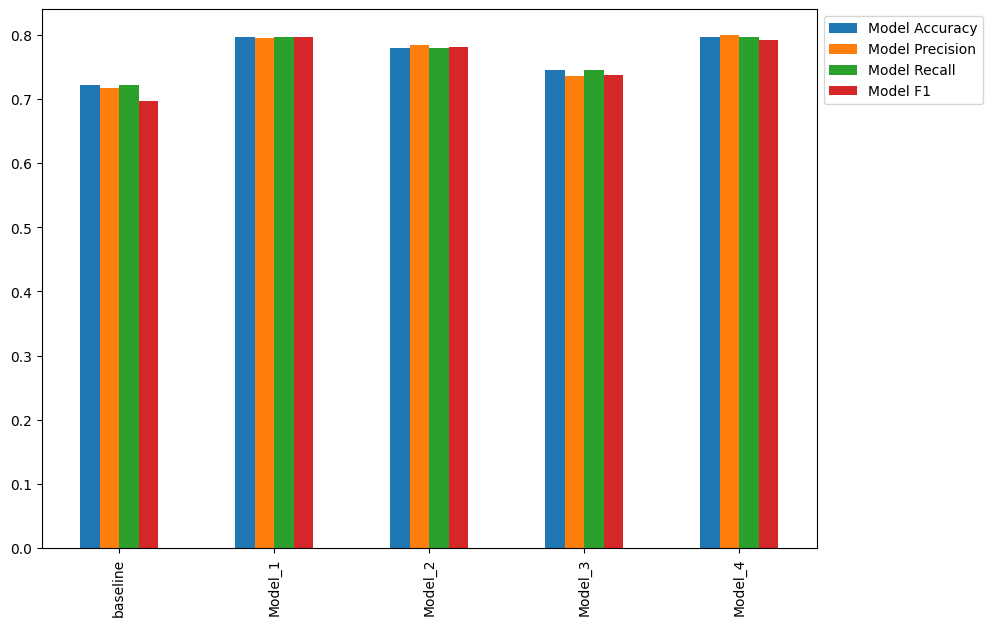

In [61]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));